In [16]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
np.random.seed(42)


"""
Designing Neural Network for the classification of tau hadronic decay and hard QCD jets

variable to use :  theta_J and N_T initially to segment phase space and then use lambda_J, r_2 and tau_31 to analyze the subspaces using multi-variate analysis
files given  : signal (tauhadronic_out.root) and background (hardqcd_200k_minpt50_out.root)
"""
variables = ['trackno', 'thetaJ', 'LambdaJ', 'ecfdr2', 'tau1'] # choices informed by the paper

def create_df(file_name, label):
    file = uproot.open(f"../dataset/{file_name}.root")  # Corrected path
    tree_name = list(file.keys())[0]
    tree = file[tree_name]
    df = tree.arrays(library="pd")[variables]
    df["label"] = label
    return df

#create a parquet file from the root file
def write_parquet(file_name):
    file  = uproot.open(f"../dataset/{file_name}.root")  # Corrected path
    tree_name = list(file.keys())[0]
    tree = file[tree_name]
    df = tree.arrays(library="pd")
    df.to_parquet(f"../dataset/converted/converted_{file_name}.parquet", index=False)  # Save in /content/
    print(f"saved {file_name}.parquet")
    return

if __name__ == "__main__":

    signal_file = "tauhadronic1L_minpt50_out"
    background_file = "hardqcd_200k_minpt50_out2"

    # write_parquet(signal_file)
    # write_parquet(background_file)

    signal_df = create_df(signal_file, 1)
    background_df = create_df(background_file, 0)

    print(len(signal_df), len(background_df))

    write_parquet(signal_file)
    write_parquet(background_file)

    df = pd.concat([signal_df, background_df], axis=0)
    df = df.sample(frac=1).reset_index(drop=True)

    X = df[variables]
    y = df["label"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

27956 97708
saved tauhadronic1L_minpt50_out.parquet
saved hardqcd_200k_minpt50_out2.parquet
Training samples: 100531, Testing samples: 25133


In [17]:
df.head()

,trackno,thetaJ,LambdaJ,ecfdr2,tau1,label
0,3.0,-0.044449,-0.226423,1.539101e-01,-0.620802,0
1,1.0,-0.485420,-0.649732,1.388891e-07,-1.251837,1
2,2.0,-0.099023,-0.284290,8.358428e-02,-0.587081,0
3,8.0,-0.075547,-0.163599,1.813725e-01,-0.381462,0
4,6.0,-0.616807,-0.206584,1.201188e-01,-0.764259,0


In [18]:
df.columns

Index(['trackno', 'thetaJ', 'LambdaJ', 'ecfdr2', 'tau1', 'label'], dtype='object')

In [19]:
signal_df.columns

Index(['trackno', 'thetaJ', 'LambdaJ', 'ecfdr2', 'tau1', 'label'], dtype='object')

In [6]:
background_df.columns

Index(['thetaJ', 'trackno', 'LambdaJ', 'ecfr2', 'tau31', 'trackno', 'thetaJ',
       'LambdaJ', 'ecfdr2', 'tau1', 'label'],
      dtype='object')

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt

X = df.drop(columns=["label"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)
    
class BetterNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3):
        super(BetterNN, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.bn3 = nn.BatchNorm1d(hidden_dim // 4)
        self.fc4 = nn.Linear(hidden_dim // 4, output_dim)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        return self.softmax(x)

hidden_dim = 256 # Number of hidden neurons
learning_rate = 1e-3  # Learning rate
batch_size = 64  # Batch size
epochs = 30  # Number of epochs

model = BetterNN(X_train.shape[1], hidden_dim, len(np.unique(y_train)))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train_tensor.size(0))  # Shuffle the training data
    epoch_loss = 0.0
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")


model.eval()
with torch.no_grad():
    y_prob = model(X_test_tensor)
    y_pred = torch.argmax(y_prob, axis=1)    
    y_prob = y_prob.numpy()[:,1]
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Epoch 1/30, Loss: 584.7593
Epoch 2/30, Loss: 571.5081
Epoch 3/30, Loss: 568.3554
Epoch 4/30, Loss: 565.4379
Epoch 5/30, Loss: 564.4376
Epoch 6/30, Loss: 563.6382
Epoch 7/30, Loss: 562.1288
Epoch 8/30, Loss: 560.6983
Epoch 9/30, Loss: 560.0212
Epoch 10/30, Loss: 559.8440
Epoch 11/30, Loss: 559.0175
Epoch 12/30, Loss: 558.3835
Epoch 13/30, Loss: 557.7232
Epoch 14/30, Loss: 557.6937
Epoch 15/30, Loss: 557.3771
Epoch 16/30, Loss: 556.4925
Epoch 17/30, Loss: 557.5378
Epoch 18/30, Loss: 556.4144
Epoch 19/30, Loss: 556.2634
Epoch 20/30, Loss: 556.2336
Epoch 21/30, Loss: 556.1502
Epoch 22/30, Loss: 556.3823
Epoch 23/30, Loss: 555.4879
Epoch 24/30, Loss: 556.7277
Epoch 25/30, Loss: 556.6229
Epoch 26/30, Loss: 556.2680
Epoch 27/30, Loss: 555.9147
Epoch 28/30, Loss: 555.1807
Epoch 29/30, Loss: 554.8784
Epoch 30/30, Loss: 555.2502
Accuracy: 0.9603
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     19657
           1       

Accuracy GB: 0.9602912505470895
F1-score (Micro): 0.9085242896425297
Confusion Matrix: 
[[19179   478]
 [  520  4956]]
Precision (Macro): 0.9428190270191334
Recall (Macro): 0.9403615690613376
F1-score (Macro): 0.9415830107629256
Precision (Micro): 0.9602912505470895
Recall (Micro): 0.9602912505470895
F1-score (Micro): 0.9602912505470895


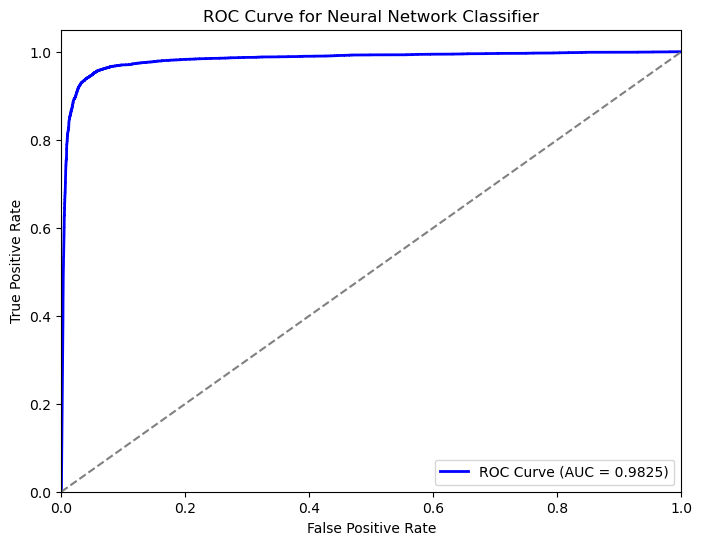

In [22]:
# Compute ROC curve and AUC
# AUC = 0.9813 for simple NN
print(f"Accuracy GB: {accuracy_score(y_test, y_pred)}")
print(f"F1-score (Micro): {f1_score(y_test, y_pred)}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")

print(f"Precision (Macro): {precision_score(y_test, y_pred, average='macro')}")
print(f"Recall (Macro): {recall_score(y_test, y_pred, average='macro')}")
print(f"F1-score (Macro): {f1_score(y_test, y_pred, average='macro')}")

print(f"Precision (Micro): {precision_score(y_test, y_pred, average='micro')}")
print(f"Recall (Micro): {recall_score(y_test, y_pred, average='micro')}")
print(f"F1-score (Micro): {f1_score(y_test, y_pred, average='micro')}")

#roc curve plot also
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Neural Network Classifier")
plt.legend(loc="lower right")

save_path = "./NN_roc_curve.png"
plt.savefig(save_path)  